In [1]:
# 对/lustre/home/hangqian/data/zircons/Roberts_Spencer_2015.csv的贝叶斯拐点分析
# time bins个数：400
# 拐点个数：3,4,5,6,7,8
# 每核采样数：1000,
# 每核burn数：1000（默认）
# 核数：1

0        2746
1        2542
2        2561
3        2028
4        2096
         ... 
42464    3505
42465    3503
42466    3508
42467    3520
42468    3044
Name: U-Pb (Ma), Length: 42469, dtype: int64
       Reference      Location  176Lu/177Hf  176Hf/177Hf        1_  U-Pb (Ma)  \
0              1        Africa      0.00110     0.280991  0.000027       2746   
1              1        Africa      0.00080     0.280998  0.000021       2542   
2              1        Africa      0.00060     0.281041  0.000020       2561   
3              1        Africa      0.00160     0.281092  0.000038       2028   
4              1        Africa      0.00110     0.281096  0.000027       2096   
...          ...           ...          ...          ...       ...        ...   
42464        166  South Africa      0.00110     0.280510  0.000032       3505   
42465        166  South Africa      0.00110     0.280586  0.000028       3503   
42466        166  South Africa      0.00110     0.280535  0.000041      

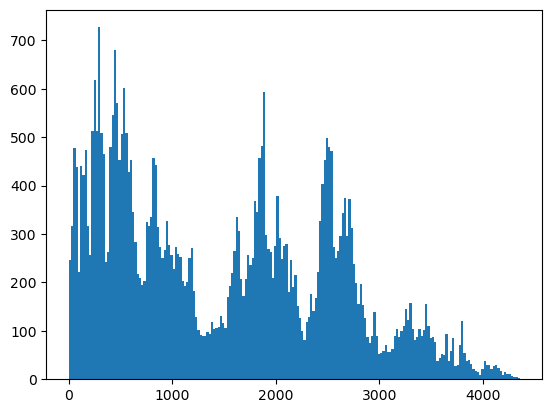

In [2]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import numpy as np
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from scipy.stats import poisson
from patsy import dmatrices
import statsmodels.graphics.tsaplots as tsa
from matplotlib import pyplot as plt
from statsmodels.tools.numdiff import approx_hess1, approx_hess2, approx_hess3
import pandas as pd
import pymc as pm
import pytensor.tensor as at

df = pd.read_csv('/lustre/home/hangqian/projects/data/zircons/Roberts_Spencer_2015.csv')
years = df["U-Pb (Ma)"]
data = plt.hist(years, bins = 200)
print(years)
print(df)
print(f"Running on PyMC v{pm.__version__}")

In [3]:
at.as_tensor

<function pytensor.tensor.as_tensor_variable(x: Union[pytensor.graph.basic.Variable, Sequence[pytensor.graph.basic.Variable], ForwardRef('ArrayLike')], name: Optional[str] = None, ndim: Optional[int] = None, **kwargs) -> 'TensorVariable'>

200
4358.0


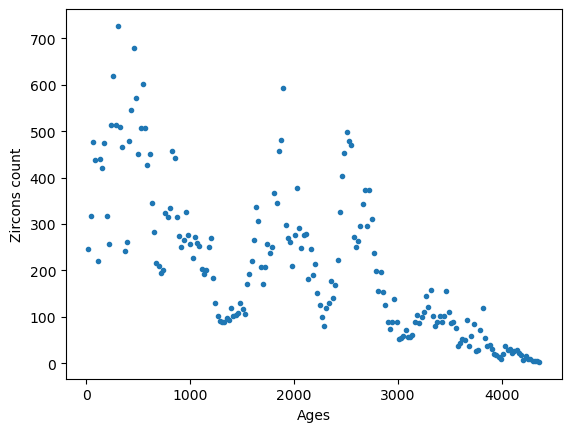

In [4]:
zircons_data = data[0]
ages = data[1][1:]
print(len(ages))
print(max(ages))
plt.plot(ages, zircons_data, "o", markersize=3, alpha=1)
plt.ylabel("Zircons count")
plt.xlabel("Ages");

In [5]:
tr =pm.distributions.transforms

Order = tr.Ordered()

#Logodd = tr.LogOddsTransform()

#chain_tran = tr.Chain([Logodd, Order])

In [6]:
with pm.Model() as model:
    
    k = pm.DiscreteUniform(name = "k",lower = 2, upper = 5)
    step = (max(ages)-200)/k
    
    rates = pm.Exponential("rates",1.0,shape = k + 1)
    
    switchpoints = pm.Uniform("switchpoints", lower = 0, upper = max(ages) , shape = k, transform = Order,  initval=at.arange(100,max(ages)-100,step))
    #x = pm.Uniform("x", 0.0, 1.0, shape = n, transform = chain_tran)
    
    rate = rates[0]
    index = 0

    #sequence= at.arange(0,k)
    
    #for i in sequence:
        #rate = pm.math.switch(switchpoints[i] >= ages, rate, rates[i+1])
        #index += 1 

    for i in range(5):
        if pm.math.gt(i,k-1):
            break
        rate = pm.math.switch(switchpoints[i] >= ages, rate, rates[i+1])

    disasters = pm.Poisson("counts", rate, observed=zircons_data)
    
    tr = pm.sample(draws = 10000, tune = 1000, cores = 1)

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [k]
>NUTS: [rates, switchpoints]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 102 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


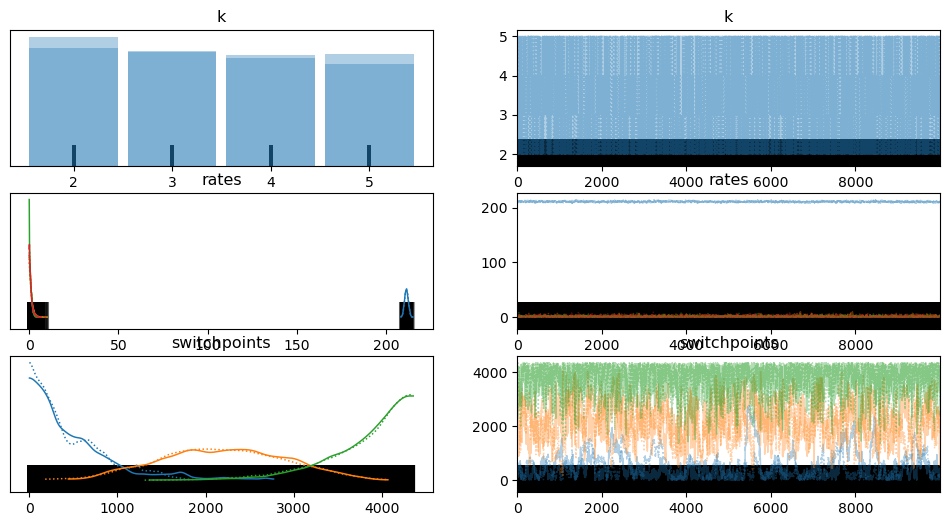

In [7]:
with model:
    az.plot_trace(tr)

In [8]:
pm.summary(tr)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
k,3.441,1.123,2.000,5.000,0.018,0.013,3774.0,4375.0,1.00
rates[0],211.283,1.017,209.433,213.192,0.038,0.027,722.0,1431.0,1.01
rates[1],1.068,1.053,0.001,2.992,0.027,0.019,1149.0,1132.0,1.00
rates[2],0.892,0.866,0.001,2.367,0.061,0.043,68.0,75.0,1.02
rates[3],1.012,0.986,0.000,2.843,0.047,0.034,249.0,190.0,1.01
switchpoints[0],483.757,454.610,0.052,1343.140,48.261,34.679,107.0,117.0,1.02
switchpoints[1],2192.013,704.815,897.436,3479.441,42.455,30.052,275.0,708.0,1.00
switchpoints[2],3816.630,478.399,2928.390,4357.960,12.535,8.925,1436.0,2998.0,1.00


In [11]:
with pm.Model() as model:
    
    k = pm.DiscreteUniform(name = "k",lower = 2, upper = 5)
    step = (max(ages)-200)/k
    
    rates = pm.Exponential("rates",1.0,shape = k + 1)
    
    switchpoints = pm.Uniform("switchpoints", lower = 0, upper = max(ages) , shape = k, transform = Order,  initval=at.arange(100,max(ages)-100,step))
    #x = pm.Uniform("x", 0.0, 1.0, shape = n, transform = chain_tran)
    
    rate = rates[0]
    index = 0

    #sequence= at.arange(0,k)
    
    #for i in sequence:
        #rate = pm.math.switch(switchpoints[i] >= ages, rate, rates[i+1])
        #index += 1 

    for i in range(5):
        if pm.math.gt(i,k-1):
            break
        rate = pm.math.switch(switchpoints[i] >= ages, rate, rates[i+1])

    disasters = pm.Poisson("counts", rate, observed=zircons_data)
    
    tr = pm.sample(draws = 30000, tune = 1000, cores = 1)

ValueError: Bad shape in start point:
Expected shape (3,) for var 'rates_log__', got: (4,)
Expected shape (2,) for var 'switchpoints_ordered__', got: (3,)